In [1]:
pip install MetaTrader5 matplotlib mplfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# === モジュールインポート ===
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import time
import requests
import talib
import datetime
from scipy.signal import savgol_filter
from scipy.stats import linregress
import matplotlib.pyplot as plt
import mplfinance.original_flavor as mpf

# === 初期設定 ===
SYMBOL = "USD"
TO_SYMBOL = "JPY"
TIMEFRAME = mt5.TIMEFRAME_M1
MAX_BARS = 500
SL_PIPS = 3
TP_PIPS = 6
POSITION_SIZE = 0.1

# === データ取得 ===
def fetch_data(SYMBOL, TO_SYMBOL):
    price = []
    params = {"fsym": SYMBOL, "tsym": TO_SYMBOL, "limit": 2000}
    while True:
        try:
            response = requests.get("https://min-api.cryptocompare.com/data/histominute", params, timeout=10)
            data = response.json()
            if data.get("Response") != "Success" or not data.get("Data"):
                time.sleep(10)
                continue
            break
        except Exception:
            time.sleep(10)

    for i in data["Data"]:
        price.append({
            "close_time": i["time"],
            "open": i["open"],
            "high": i["high"],
            "low": i["low"],
            "close": i["close"],
            "volumeto": i["volumeto"]
        })
    df = pd.DataFrame(price)
    df['close_time'] = pd.to_datetime(df['close_time'], unit='s')
    df.set_index('close_time', inplace=True)
    for col in ['open', 'high', 'low', 'close', 'volumeto']:
        df[col] = df[col].astype(float)
    return df

# === g_trendlines 関連 ===
class FXBase():
    candles = None
    def __init__(self):
        cols = ['col1', 'col2']
        FXBase.candles = pd.DataFrame(index=[], columns=cols)

def get_highpoint(start, end):
    chart = FXBase.candles[start:end+1]
    while len(chart)>3:
        regression = linregress(x=chart['time_id'], y=chart['high'])
        chart = chart.loc[chart['high'] > regression[0]*chart['time_id'] + regression[1]]
    return chart

def get_lowpoint(start, end):
    chart = FXBase.candles[start:end+1]
    while len(chart)>3:
        regression = linregress(x=chart['time_id'], y=chart['low'])
        chart = chart.loc[chart['low'] < regression[0]*chart['time_id'] + regression[1]]
    return chart

def g_trendlines(span=100, min_interval=6):
    trendlines = []
    for i in FXBase.candles.index[::int(span/2)]:
        highpoint = get_highpoint(i, i + span)
        if len(highpoint) >= 2 and abs(highpoint.index[0] - highpoint.index[1]) >= min_interval:
            reg = linregress(x=highpoint['time_id'], y=highpoint['high'])
            if reg[0] < 0.0:
                line = reg[0] * FXBase.candles['time_id'][i:i+span*2] + reg[1]
                trendlines.append(line)
        lowpoint = get_lowpoint(i, i + span)
        if len(lowpoint) >= 2 and abs(lowpoint.index[0] - lowpoint.index[1]) >= min_interval:
            reg = linregress(x=lowpoint['time_id'], y=lowpoint['low'])
            if reg[0] > 0.0:
                line = reg[0] * FXBase.candles['time_id'][i:i+span*2] + reg[1]
                trendlines.append(line)
    return trendlines

# === 傾き計算 ===
def calc_slope(line, window=5):
    if len(line) < window:
        return 0
    y = np.array(line[-window:])
    x = np.arange(window)
    return np.polyfit(x, y, 1)[0]

# === シグナル判定（g_trendlines 押し目判定付き） ===
def judge_trade_dp(df, high_lines, low_lines, g_trends, margin=0.0, slope_th=0.01):
    signals = []
    closes = df['close'].values
    highs = df['high'].values
    lows = df['low'].values
    adx = talib.ADX(df['high'], df['low'], df['close'], timeperiod=14)
    for i in range(len(df)):
        if i < 1 or i >= len(closes):
            signals.append(None)
            continue

        close = closes[i]
        high = highs[i]
        low = lows[i]
        sig = None
        for line in g_trends:
            if i in line.index:
                if i < 3 and i >= len(line) - 3:
                    signals.append(None)
                    continue
                trend_price = line.loc[i]
                slope = calc_slope(line.tolist())
                dist = abs(close - trend_price / close)
                if slope > slope_th and low > trend_price and adx[i] > 22 and adx[i] > adx[i-5]:
                    sig = "PULLBACK_BUY"
                    break
                elif slope < -slope_th and high < trend_price and adx[i] > 22 and adx[i] > adx[i-5]:
                    sig = "PULLBACK_SELL"
                    break
        signals.append(sig)
    return signals

# === 簡易勝率評価 ===
def calc_winrate(df, open_, close, high, low, g_trends, entry_minutes=10, tp_pips=8, sl_pips=5, spread=0.02, symbol="USDJPY", lot=1000, start_balance=50000, leverage=3):
    signals = judge_trade_dp(df, [], [], g_trends)
    entries, results = [], []
    pips_unit = 0.01 if "JPY" in symbol else 0.0001
    tp = tp_pips * pips_unit
    sl = sl_pips * pips_unit
    open_, close = open_.reset_index(drop=True), close.reset_index(drop=True)
    high, low = high.reset_index(drop=True), low.reset_index(drop=True)
    balance = start_balance
    for i, sig in enumerate(signals):
        if sig and i + entry_minutes + 1 < len(close):
            price = close[i + 1] + spread if "BUY" in sig else close[i + 1] - spread
            highs = high[i+1:i+1+entry_minutes]
            lows = low[i+1:i+1+entry_minutes]
            hit = False
            if sig == "PULLBACK_BUY":
                for idx, (h, l) in enumerate(zip(highs, lows)):
                    # 損切
                    if l <= price - sl <= h:
                        balance -= lot * sl * leverage
                        results.append(False)
                        hit = True
                        break
                    # 利確
                    elif l <= price + tp <= h:
                        balance += lot * tp * leverage
                        results.append(True)
                        hit = True
                        break
                if not hit:
                    # 約定しなかった場合、区間最後の終値で決済
                    exit_price = close[i + 1 + entry_minutes]
                    pnl = (exit_price - price) * lot * leverage
                    balance += pnl
                    results.append(pnl > 0)
            elif sig == "PULLBACK_SELL":
                for idx, (h, l) in enumerate(zip(highs, lows)):
                    # 損切
                    if l <= price + sl <= h:
                        balance -= lot * sl * leverage
                        results.append(False)
                        hit = True
                        break
                    # 利確
                    elif l <= price - tp <= h:
                        balance += lot * tp * leverage
                        results.append(True)
                        hit = True
                        break
                if not hit:
                    # 約定しなかった場合、区間最後の終値で決済
                    exit_price = close[i + 1 + entry_minutes]
                    pnl = (price - exit_price) * lot * leverage
                    balance += pnl
                    results.append(pnl > 0)
            entries.append(i)
        if balance <= 0:
            break
    winrate = sum(results) / len(results) if results else None
    print(f"[WinRate] {winrate:.2%} ({len(results)} trades)" if winrate else "[WinRate] N/A")
    print(f"[Balance] {balance:.2f} (Start: {start_balance})")
    return winrate, entries, results, signals

def calc_winrate2(df, open_, close, high, low, g_trends, tp_pips=8, sl_pips=5, spread=0.02, symbol="USDJPY", lot=1000, start_balance=50000, leverage=3):
    signals = judge_trade_dp(df, [], [], g_trends)
    entries, results = [], []
    pips_unit = 0.01 if "JPY" in symbol else 0.0001
    tp = tp_pips * pips_unit
    sl = sl_pips * pips_unit
    open_, close = open_.reset_index(drop=True), close.reset_index(drop=True)
    high, low = high.reset_index(drop=True), low.reset_index(drop=True)
    balance = start_balance
    for i, sig in enumerate(signals):
        if sig and i + 1 < len(close):
            price = close[i + 1] + spread if "BUY" in sig else close[i + 1] - spread
            hit = False
            for j in range(i + 1, len(close)):
                h = high[j]
                l = low[j]
                if sig == "PULLBACK_BUY":
                    # まず損切判定
                    if l <= price - sl <= h:
                        balance -= lot * sl * leverage
                        results.append(False)
                        hit = True
                        break
                    # 次に利確判定
                    elif l <= price + tp <= h:
                        balance += lot * tp * leverage
                        results.append(True)
                        hit = True
                        break
                elif sig == "PULLBACK_SELL":
                    # まず損切判定
                    if l <= price + sl <= h:
                        balance -= lot * sl * leverage
                        results.append(False)
                        hit = True
                        break
                    # 次に利確判定
                    elif l <= price - tp <= h:
                        balance += lot * tp * leverage
                        results.append(True)
                        hit = True
                        break
            if not hit:
                results.append(False)
        entries.append(i)
        if balance <= 0:
            break
    winrate = sum(results) / len(results) if results else None
    print(f"[WinRate] {winrate:.2%} ({len(results)} trades)" if winrate else "[WinRate] N/A")
    print(f"[Balance] {balance:.2f} (Start: {start_balance})")
    return winrate, entries, results, signals
# === 実行 ===
df = fetch_data(SYMBOL, TO_SYMBOL)
FXBase.candles = df.copy().reset_index()
FXBase.candles['time_id'] = range(len(FXBase.candles))

gtrend = g_trendlines()
print(f"Trendlines generated: {len(gtrend)}")
calc_winrate(df, df['open'], df['close'], df['high'], df['low'], gtrend)
calc_winrate2(df, df['open'], df['close'], df['high'], df['low'], gtrend)

interval_minutes = 1  # 1分ごとに実行]
last_run_minute = None


Trendlines generated: 30


C:\Users\miya4\AppData\Local\Temp\ipykernel_1844\387570997.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if slope > slope_th and low > trend_price and adx[i] > 22 and adx[i] > adx[i-5]:


[WinRate] 17.65% (17 trades)
[Balance] 48620.00 (Start: 50000)
[WinRate] 17.65% (17 trades)
[Balance] 48620.00 (Start: 50000)


AttributeError: 'DataFrame' object has no attribute 'time'

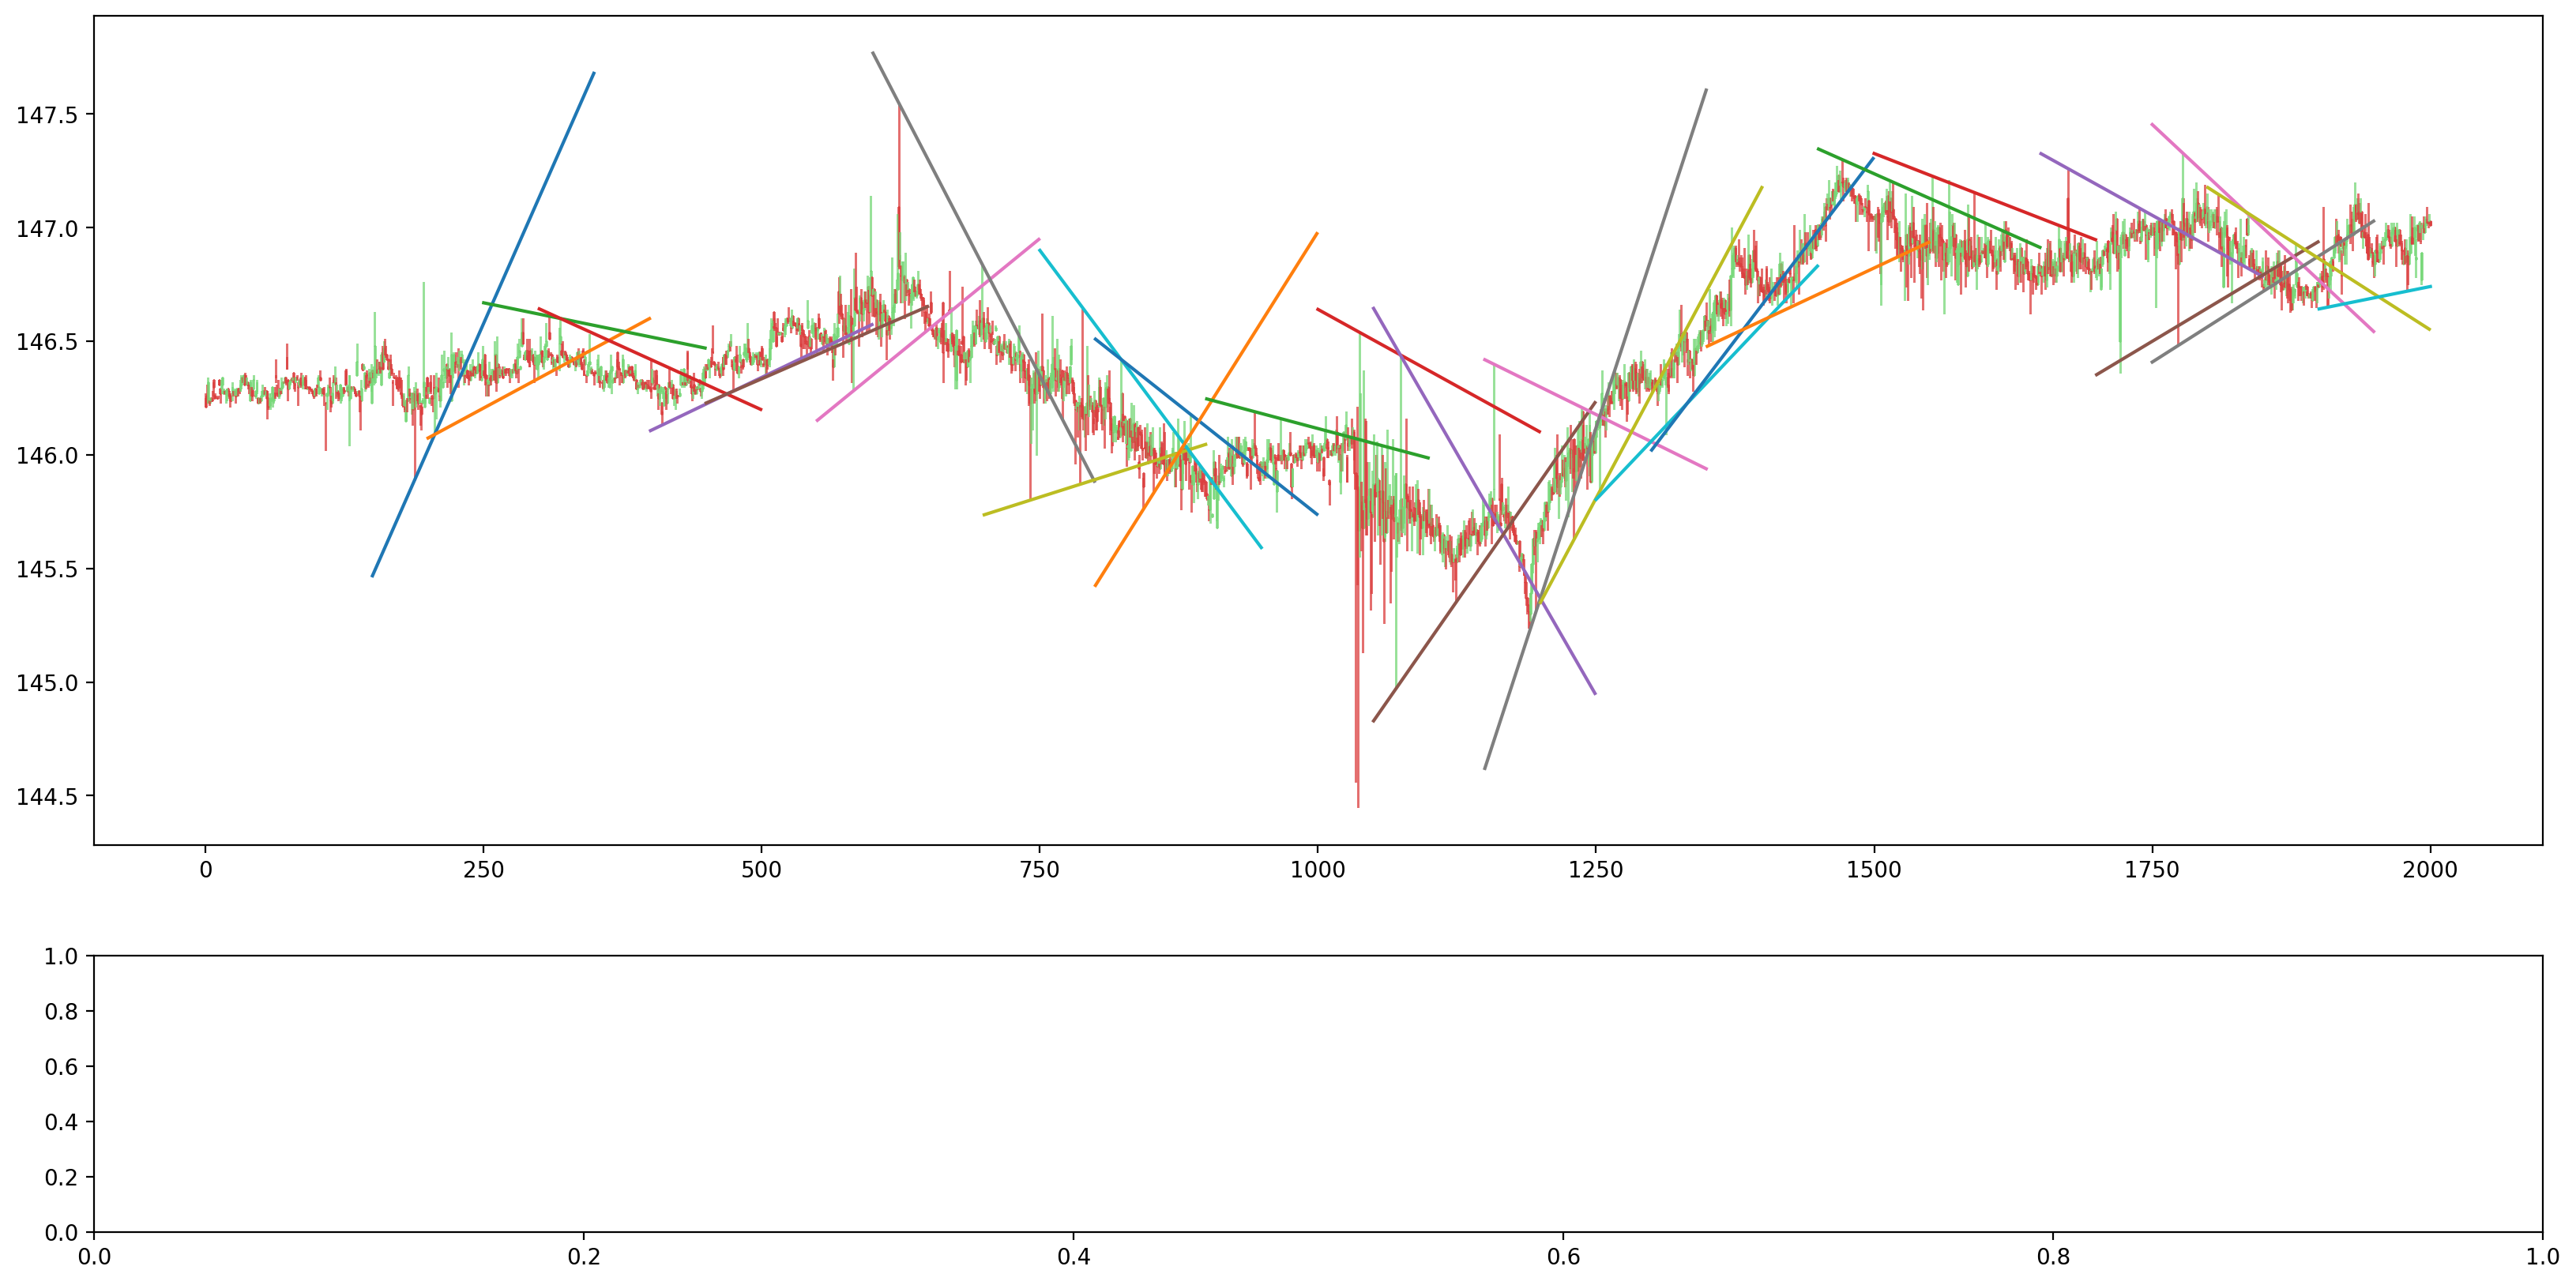

In [3]:
figure, (axis1, axis2) = plt.subplots(2, 1, figsize=(20,10), dpi=200, gridspec_kw = {'height_ratios':[3, 1]})

# ローソク足
mpf.candlestick2_ohlc(
    axis1,
    opens  = FXBase.candles.open.values,
    highs  = FXBase.candles.high.values,
    lows   = FXBase.candles.low.values,
    closes = FXBase.candles.close.values,
    width=0.6, colorup='#77d879', colordown='#db3f3f'
)

# トレンドラインたちを引く
for i, line in enumerate(g_trendlines()):
    axis1.plot(line, label=i)

# X軸の見た目を整える
xticks_number  = 12 # 12本刻みに目盛りを書く
xticks_index   = range(0, len(FXBase.candles), xticks_number)
xticks_display = [FXBase.candles.time.values[i][11:16] for i in xticks_index] # 時間を切り出すため、先頭12文字目から取る

# axis1を装飾 ( plt.sca(axis): set current axis )
plt.sca(axis1)
plt.xticks( xticks_index, xticks_display )
plt.legend()
plt.show()

# axis2は他の勉強の名残…消したら動かなくなりそうで、怖くて消せてない(´；ω；`)
